# LightGBM for BPD muti-classfication-three

In [1]:
#导包
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import xgboost as xgb
import pdb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle as pkl
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
# df = pd.read_excel('./data.xlsx') #读取数据
# from collections import Counter
# # 简单定义一个print 函数
# def print_label_dist(label_col):
#     c = Counter(label_col)
#     print(f'label is {c}')
# print_label_dist(df['label BPD grading'])
 


In [3]:
#数据预处理
df_rawdata = pd.read_excel('./data_15.xlsx') #读取数据
 

#划分10折
def make_fold(fold,df,num_fold=10):
    num_fold = num_fold
    skf = StratifiedKFold(n_splits=num_fold, shuffle=True,random_state=42)
    df.loc[:,'fold']=-1
    for f,(t_idx, v_idx) in enumerate(skf.split(X=df['ID'], y=df['label2019'])):
        df.iloc[v_idx,-1]=f
    train_df=df[df.fold!=fold].drop(['fold','ID'],axis = 1).reset_index(drop=True)
    valid_df=df[df.fold==fold].drop(['fold','ID'],axis = 1).reset_index(drop=True)
    return train_df,valid_df



In [4]:
# train_df,valid_df = make_fold(fold=0, df=df_rawdata,num_fold=10)
# Y = train_df['label BPD grading']
# Y_test = valid_df['label BPD grading']
# X = train_df.drop('label BPD grading', axis=1)
# X_test = valid_df.drop('label BPD grading', axis=1)
# # 分离离散变量
# def split_category(data, columns):
#     cat_data = data[columns]
#     rest_data = data.drop(columns, axis=1)
#     return rest_data, cat_data
# #  转所有离散变量为one-hot
# def one_hot_cat(data):
#     if isinstance(data, pd.Series):
#         data = pd.DataFrame(data, columns=[data.name])
#     out = pd.DataFrame([])
#     for col in data.columns:
#         one_hot_cols = pd.get_dummies(data[col], prefix=col)
#         out = pd.concat([out, one_hot_cols], axis=1)
#     out.set_index(data.index)
#     return out


In [5]:
# categorical_columns
# categorical_columns = ['male', 'Perinatal asphyxia', 'HsPDA', 'RF','IVH','invasive ventilation', 'surfactant therapy',]
# X[categorical_columns]
# from imblearn.over_sampling import SMOTE, ADASYN
# from sklearn.preprocessing import LabelEncoder

# def label_encoder(data):
#     labelencoder = LabelEncoder()
#     for col in data.columns:
#         data.loc[:,col] = labelencoder.fit_transform(data[col])
#     return data
# # first label_encoder to allow resampling
# X[categorical_columns] = label_encoder(X[categorical_columns])
# X_test[categorical_columns] = label_encoder(X_test[categorical_columns])

# oversample = SMOTE()
# X, Y = oversample.fit_resample(X, Y)
# X, X_cat = split_category(X, categorical_columns)
# X_test, X_test_cat = split_category(X_test, categorical_columns)
# # convert to one-hot
# X_cat_one_hot_cols = one_hot_cat(X_cat)
# X_test_cat_one_hot_cols = one_hot_cat(X_test_cat)
# # align train to test
# X_cat_one_hot_cols, X_test_cat_one_hot_cols = X_cat_one_hot_cols.align(
#     X_test_cat_one_hot_cols, join='inner',axis=1)
# X_cat_one_hot_cols.fillna(0, inplace=True)
# X_test_cat_one_hot_cols.fillna(0, inplace=True)
# X = pd.concat([X, X_cat_one_hot_cols], axis=1)
# X_test = pd.concat([X_test, X_test_cat_one_hot_cols],
#                    axis=1)
# print(f'add one-hot features')


In [6]:
# import lightgbm as lgb
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,f1_score
# feature_name = list(X.columns) # 特征名称后续会用到
# Y_encode = LabelEncoder().fit_transform(Y)
# Y_test_encode = LabelEncoder().fit_transform(Y_test)
# dtrain = lgb.Dataset(X.values, label=Y_encode)
# dtest = lgb.Dataset(X_test.values, label=Y_test_encode)
# param = {
#     'eta': 0.1,
#     'objective': 'multiclass',
#     'num_class': 3,
#     'verbose': 0,
#     'metric':'multi_error'
# } # 参数几乎都是默认值，仅仅修改一些多分类必须的参数
# evals_result = {}
# valid_sets = [dtrain, dtest]
# valid_name = ['train', 'eval']

# model = lgb.train(param, dtrain, num_boost_round=500, feature_name=feature_name,
#                   valid_sets=valid_sets, valid_names=valid_name)

# y_pred_1 = model.predict(X_test.values)

# y_pred = pd.DataFrame(y_pred_1).idxmax(axis=1) #预测概率值转为预测标签
#



In [7]:
# 随机上采样
def balance(data,target):
    df0 = data.loc[target==0].copy()
    df1 = data.loc[target==1].copy()
    df2 = data.loc[target==2].copy()
    df0 = df0.sample(n=int(df0.shape[0]), replace = True, random_state = 42)
    df1 = df1.sample(n=int(df0.shape[0]), replace = True, random_state = 42)
    df2 = df2.sample(n=int(df0.shape[0]), replace = True, random_state = 42)

    df = pd.concat([df0,df1,df2])
    tg = np.concatenate((np.zeros(len(df0)), np.ones(len(df1)),np.ones(len(df2))+1))
    return df, tg

# 特征归一化
from sklearn.preprocessing import StandardScaler
def scaler(data, feature_name):
    # feature_name = ["Fio2", "GA","BW", "IL-6", "PH", "NT-proBNP", "1-min Apgar score", "5-min Apgar score"]
    SCALER = StandardScaler()
    SCALER.fit(data[feature_name])
    data = SCALER.transform(data[feature_name])
    return data

In [8]:
def trainfold_k10(data, fold = 0):
    train_df, valid_df = make_fold(fold=fold, df=data,num_fold=10)

    #定义数据集
    categorical_features = ['male', 'asphyxia', 'HsPDA','PS','RF','IVH','invasive-ventilation ']
    X_train, y_train = train_df.drop(['label2019'], axis=1), train_df['label2019']
    X_valid, y_valid = valid_df.drop(['label2019'], axis=1), valid_df['label2019']

    X_train, y_train = balance(X_train, y_train)

    #模型定义
    model = LGBMClassifier(learning_rate=0.05,objective='multiclass',num_class=3,max_depth=5,num_leaves=15,n_estimators = 200, is_unbalance=True,early_stopping_round = 20,random_state=42)
    #模型训练
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid),categorical_feature=categorical_features)
    plt.figure(figsize=(100,100))
    lgb.plot_importance(model, max_num_features=20,grid=False, height=0.5,ylabel='Features',xlabel='F score')
    # plot_importance(booster, ax=None, height=0.2,xlim=None, ylim=None, 
    # title='Feature importance',xlabel='F score', 
    # ylabel='Features',importance_type='weight', 
    # max_num_features=None,grid=True, show_values=True, 
    # **kwargs)
    
    lgb.plot_importance(model, max_num_features=20,grid=False, height=0.5,ylabel='Features',xlabel='F score')
    plt.title("Feature importance of LightGBM")
    plt.savefig('./featurertancesLGB.png')
    plt.show()
    return y_valid, model.predict_proba(X_valid)
    

In [9]:
# feature_name = ["Fio2", "GA","BW", "IL-6", "PH", "NT-proBNP", "1-min Apgar score", "5-min Apgar score"]
# scaler_df = scaler(df_rawdata, feature_name)
# for i in range(8):
#     df_rawdata[feature_name[i]] = scaler_df[:,i]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 834, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

<Figure size 7200x7200 with 0 Axes>

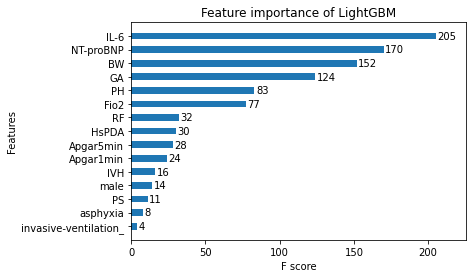

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 834, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

<Figure size 7200x7200 with 0 Axes>

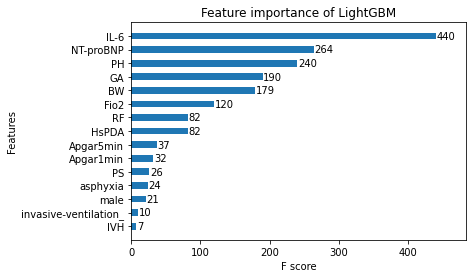

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 834, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

<Figure size 7200x7200 with 0 Axes>

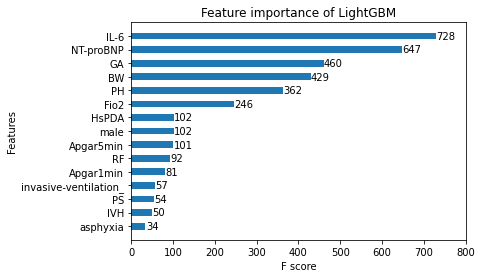

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 834, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

<Figure size 7200x7200 with 0 Axes>

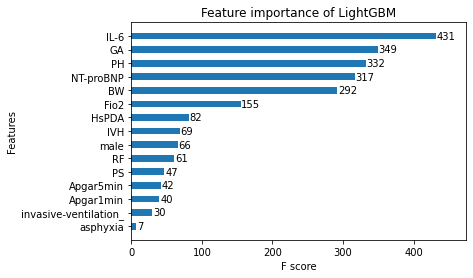

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 545
[LightGBM] [Info] Number of data points in the train set: 834, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

<Figure size 7200x7200 with 0 Axes>

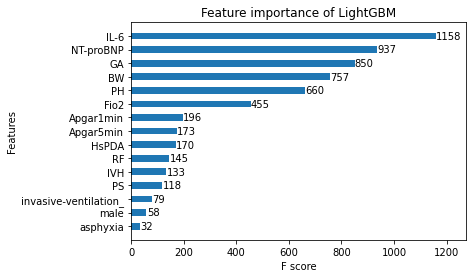

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 834, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

<Figure size 7200x7200 with 0 Axes>

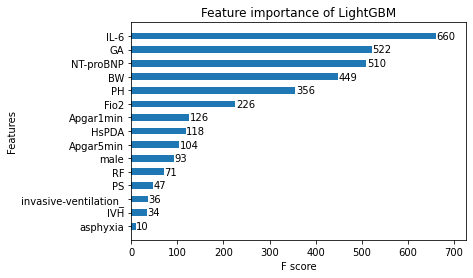

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 834, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

<Figure size 7200x7200 with 0 Axes>

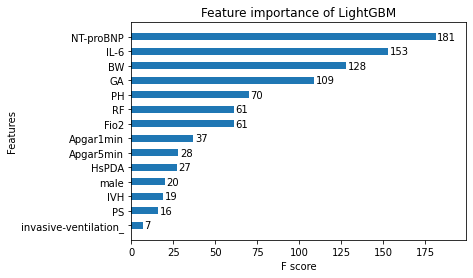

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 834, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

<Figure size 7200x7200 with 0 Axes>

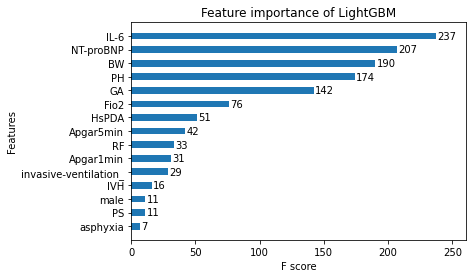

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 834, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

<Figure size 7200x7200 with 0 Axes>

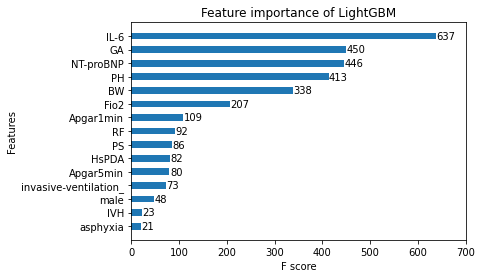

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 837, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

<Figure size 7200x7200 with 0 Axes>

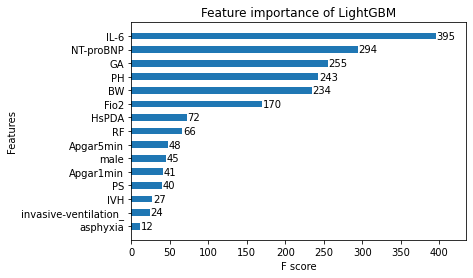

In [10]:
labellist = []
prelist = []
for i in range(10):
    label, pre = trainfold_k10( df_rawdata,fold = i)
    labellist.append(label)
    prelist.append(pre)

# #评估推理
# trainauc = roc_auc_score(y_train,model.predict_proba(X_train),multi_class='ovr')
# validauc = roc_auc_score(y_valid,model.predict_proba(X_valid),multi_class='ovr')
# print('训练集auc:',trainauc)
# print('验证集auc:',validauc)

In [11]:
labellist = pd.concat(labellist)

In [12]:
prelist

[array([[0.46978035, 0.30174161, 0.22847804],
        [0.8179732 , 0.09464637, 0.08738043],
        [0.72682096, 0.18012368, 0.09305536],
        [0.31802553, 0.32711227, 0.3548622 ],
        [0.48098289, 0.33846296, 0.18055415],
        [0.28898846, 0.32443627, 0.38657527],
        [0.56067091, 0.32534967, 0.11397941],
        [0.65308308, 0.25069008, 0.09622684],
        [0.769809  , 0.14383424, 0.08635676],
        [0.75214757, 0.15496209, 0.09289033],
        [0.16289708, 0.28934376, 0.54775916],
        [0.22972548, 0.65777523, 0.11249929],
        [0.63202783, 0.28895356, 0.0790186 ],
        [0.67902946, 0.21748768, 0.10348285],
        [0.75040433, 0.11492772, 0.13466795],
        [0.72016475, 0.17391937, 0.10591588],
        [0.61563585, 0.30976911, 0.07459504],
        [0.48745779, 0.32403265, 0.18850955],
        [0.68186783, 0.23453978, 0.08359239],
        [0.21699738, 0.12071133, 0.66229129],
        [0.44012344, 0.45892169, 0.10095487],
        [0.44547667, 0.42325219, 0

In [13]:
# print(f'acc score is {accuracy_score(Y_test_encode, y_pred)}')
# print(confusion_matrix(Y_test_encode, y_pred))
# print(classification_report(Y_test_encode, y_pred, digits=3))

# auc = roc_auc_score(Y_test_encode, y_pred_1, multi_class='ovo', average='macro') # 选用macro 很重要。参考sklearn。
# #Calculate metrics for each label, and find their unweighted mean. #This does not take label imbalance into account.
# print(f'roc_auc_score  is {auc}')

# f1 = f1_score(y_pred, Y_test_encode, average='macro')
# print(f'f1_score  is {f1}')


In [14]:
prelist = np.concatenate(prelist)

In [15]:
labellist

0     0
1     0
2     0
3     0
4     0
     ..
36    1
37    1
38    2
39    2
40    2
Name: label2019, Length: 414, dtype: int64

3


/tmp/ipykernel_74501/948751974.py:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


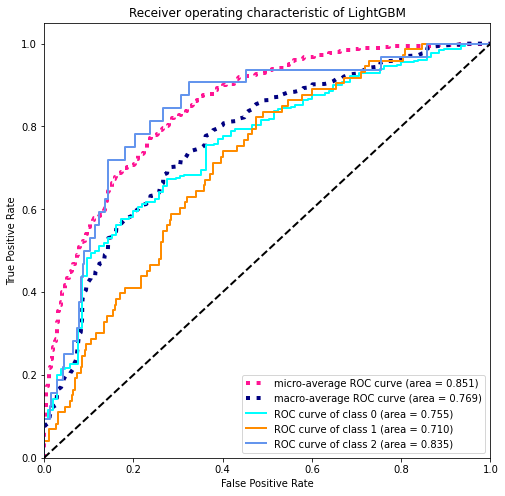

In [16]:
# 引入必要的库
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# 将标签二值化 即：变成[1 0 0] [0 0 1] [0 1 0]
y_test = label_binarize(labellist, classes=[0, 1, 2])
# print(len(y))
# 设置种类
n_classes = 3
print(n_classes)

# # 训练模型并预测
# random_state = np.random.RandomState(0)
# n_samples, n_features = x.shape

# # shuffle and split training and test sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5,random_state=0)

# # Learn to predict each class against the other
# classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
#                                  random_state=random_state))
# y_score = classifier.fit(x_train, y_train).decision_function(x_test)
y_score = prelist
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes): # 遍历三个类别
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.3f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of LightGBM')
plt.legend(loc="lower right")
plt.savefig('./roclgb.png')
plt.show()

In [17]:

from sklearn import  metrics

In [18]:
num=num0=num1=num2=0.0
acc=acc0=acc1=acc2=0.0
prelabel = prelist.argmax(-1)
reallabel = labellist.to_list()

In [19]:
for i in range(len(reallabel)):
    num += 1
    if reallabel[i]==0:
        num0 +=1
        if prelabel[i]==reallabel[i]:
            acc0 +=1
            acc +=1
    if reallabel[i]==1:
        num1 +=1
        if prelabel[i]==reallabel[i]:
            acc1 +=1
            acc+=1
    if reallabel[i]==2:
        num2 +=1
        if prelabel[i]==reallabel[i]:
            acc2 +=1
            acc+=1

In [20]:
print(f'acc score is {accuracy_score(prelabel, reallabel)}')
print(confusion_matrix(prelabel, reallabel))
print(classification_report(prelabel, reallabel, digits=3))

acc score is 0.678743961352657
[[235  30  10]
 [ 47  30   6]
 [ 27  13  16]]
              precision    recall  f1-score   support

           0      0.761     0.855     0.805       275
           1      0.411     0.361     0.385        83
           2      0.500     0.286     0.364        56

    accuracy                          0.679       414
   macro avg      0.557     0.501     0.518       414
weighted avg      0.655     0.679     0.661       414



In [21]:
acc/num

0.678743961352657

In [22]:
acc0/num0

0.7605177993527508

In [23]:
acc1/num1

0.410958904109589

In [24]:
acc2/num2

0.5

In [25]:
prelist.argmax(-1)

array([0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 1, 2, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 2, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 0, 1, 0, 1,
       1, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,